# Notebook 2: Na'vi River Journey EDA & Modeling

Capstone Project - Nadia W. Morgen

# Data & Library Imports

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pmd
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

import statsmodels.api as sm

# We are required to do this in order to avoid "FutureWarning" issues.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()  
plt.style.use('fivethirtyeight')

In [2]:
navi_posted = pd.read_csv('data/navi_posted.csv')
navi_actl = pd.read_csv('data/navi_actl.csv')

# EDA - Na'vi River Journey

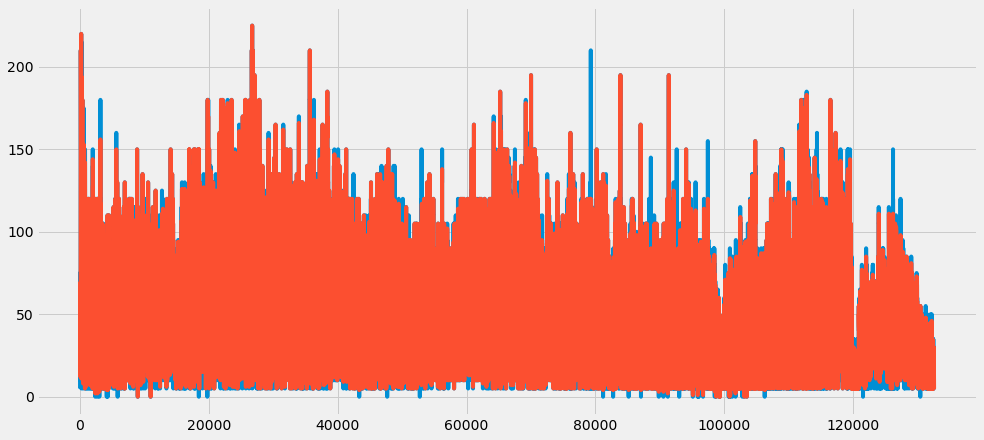

In [3]:
plt.figure(figsize = (15, 7))
plt.plot(navi_posted['SPOSTMIN'])
plt.plot(navi_posted['SPOSTMIN'].rolling(5).mean());


The data are imperfect.  There are days when there are multiple values recorded and days where there are none.  We see more missing data in 2020.  A large chunk of that was due to park closures due to COVID.  However, this doesn't explain the gap between Jan, 2021 and July, 2021.

In any case the rolling means of posted waiting times and posted waiting times overlap highly.

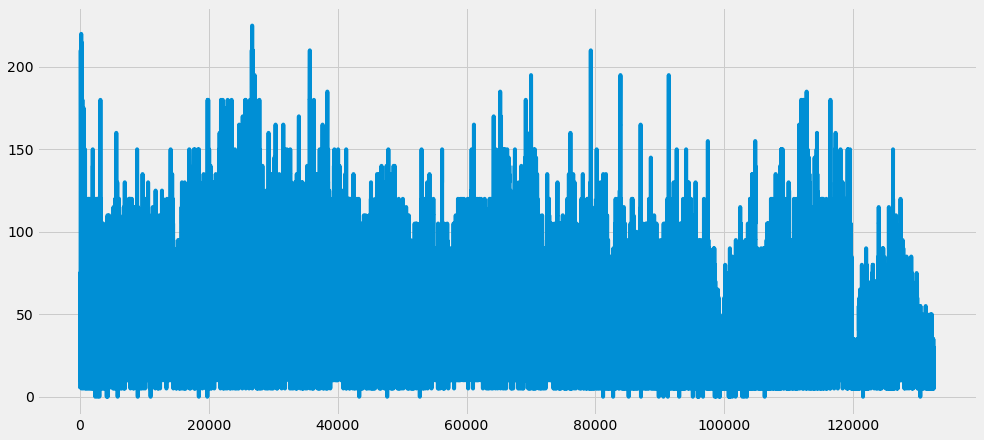

In [4]:
plt.figure(figsize = (15, 7))
plt.plot(navi_posted['SPOSTMIN']);

In [5]:
navi_posted['SPOSTMIN'].min()

0.0

In [6]:
navi_posted['SPOSTMIN'].max()

225.0

In [7]:
# Start calculating average wait time by day
navi_posted.head(2)

,date,datetime,SACTMIN,SPOSTMIN,weekday,day_name
0,2017-05-26,2017-05-26 09:10:12,NaN,5.0,5,Friday
1,2017-05-26,2017-05-26 09:17:09,NaN,45.0,5,Friday


In [8]:
navi_posted.dtypes

date         object
datetime     object
SACTMIN     float64
SPOSTMIN    float64
weekday       int64
day_name     object
dtype: object

Apparently, I have to reconvert the fields into my desired datatypes and reestablish date as the index.

In [9]:
navi_posted['date'] = pd.to_datetime(navi_posted['date'])
navi_posted['datetime'] = pd.to_datetime(navi_posted['datetime'])
navi_posted['day_name'] = navi_posted.day_name.astype('string')

navi_actl['date'] = pd.to_datetime(navi_actl['date'])
navi_actl['datetime'] = pd.to_datetime(navi_actl['datetime'])

# Also creating two dataframes, one indexed on date, the other indexed on datetime
navi_date = navi_posted.copy()
#navi_date.set_index('date', inplace = True)

navi_dt = navi_posted.copy()
navi_dt.set_index('datetime', inplace = True)

navi_posted.set_index('date', inplace = True)
navi_actl.set_index('date', inplace = True)

In [10]:
navi_posted['avg_daily_posted_wait'] = navi_posted.groupby('date')['SPOSTMIN'].mean()

In [11]:
navi_posted.head(3)

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,avg_daily_posted_wait
date,,,,,,
2017-05-26,2017-05-26 09:10:12,NaN,5.0,5,Friday,38.896104
2017-05-26,2017-05-26 09:17:09,NaN,45.0,5,Friday,38.896104
2017-05-26,2017-05-26 09:24:07,NaN,45.0,5,Friday,38.896104


In [12]:
# Calculate average waiting time over the course of a specific day
av_daily_wait = navi_posted.drop(columns=['SACTMIN', 'SPOSTMIN', 'datetime'])

In [13]:
# Get rid of duplicates for readability

av_daily_wait.drop_duplicates(subset=None, keep='first', inplace=True)

In [14]:
av_daily_wait.head()

,weekday,day_name,avg_daily_posted_wait
date,,,
2017-05-26,5,Friday,38.896104
2017-05-27,6,Saturday,149.453125
2017-05-28,7,Sunday,115.821429
2017-05-29,1,Monday,103.867188
2017-05-30,2,Tuesday,92.500000


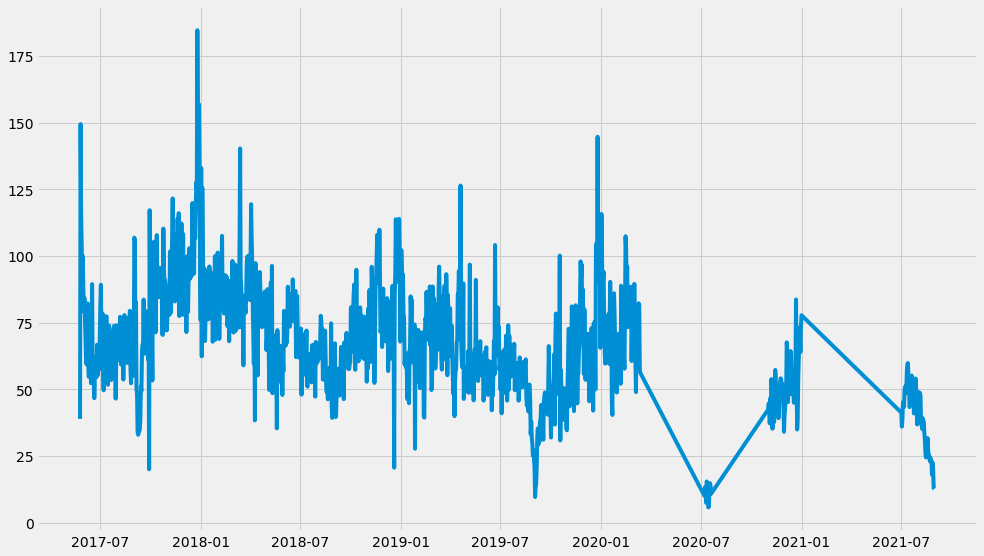

In [15]:
plt.figure(figsize = (15, 9))
plt.plot(av_daily_wait['avg_daily_posted_wait'], label='Average Daily Wait Time Since Navi River Opened');

In [16]:
#navi_posted['avg_daily_posted_wait'] = navi_posted.groupby('date')['SPOSTMIN'].mean()

In [17]:
# Calculate average daily wait based on day of the week (all Mondays, etc.)

av_daily_wait_2 = av_daily_wait.groupby('day_name')['avg_daily_posted_wait'].mean()

In [18]:
av_daily_wait_2

day_name
Friday       68.163955
Monday       69.663842
Saturday     70.446668
Sunday       64.867884
Thursday     67.966700
Tuesday      66.955852
Wednesday    63.366831
Name: avg_daily_posted_wait, dtype: float64

Average daily wait time for the Na'vi River Journey is just over an hour.  There is not much difference from day to day.  However, this includes pre-covid data. I'm going to calculate the same metric on covid era data.

In [19]:
av_daily_wait_2 = pd.DataFrame()

In [20]:
av_daily_wait_2.dtypes

Series([], dtype: object)

In [21]:
# copy database then filter all post-covid dates
navi_thru_18 = navi_posted.copy()
navi_thru_18.head()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,avg_daily_posted_wait
date,,,,,,
2017-05-26,2017-05-26 09:10:12,NaN,5.0,5,Friday,38.896104
2017-05-26,2017-05-26 09:17:09,NaN,45.0,5,Friday,38.896104
2017-05-26,2017-05-26 09:24:07,NaN,45.0,5,Friday,38.896104
2017-05-26,2017-05-26 09:30:10,NaN,45.0,5,Friday,38.896104
2017-05-26,2017-05-26 09:45:32,NaN,45.0,5,Friday,38.896104


In [22]:
navi_thru_18 = navi_thru_18[navi_thru_18.datetime < '2019-01-01']

In [23]:
navi_thru_18.max()

datetime                 2018-12-31 20:59:07
SACTMIN                                  NaN
SPOSTMIN                               225.0
weekday                                    7
day_name                           Wednesday
avg_daily_posted_wait             184.649123
dtype: object

In [24]:
# Create df for COVID era
navi_covid = navi_posted.copy()
navi_covid = navi_covid[navi_posted.datetime >= '2020-01-01']

In [25]:
av_daily_wait_covid = navi_covid.groupby('day_name')['avg_daily_posted_wait'].mean()

In [26]:
av_daily_wait_covid

day_name
Friday       54.099190
Monday       53.704096
Saturday     56.204279
Sunday       53.599864
Thursday     52.252560
Tuesday      54.283565
Wednesday    52.261600
Name: avg_daily_posted_wait, dtype: float64

It appears that wait times decreased approximately 15 minutes during covid.

# Modeling

The next step is to model ride data based on the pre-covid years and test it on the covid years.  I shall aggregate the data hourly, daily, and weekly.  Additionally, I'll aggregate the data monthly for December.

Lastly, I will attempt to use that model to predict wait times for November, December and January.  Predicting Fall, 2021 wait times for Na'vi River Journey is particularly challenging because my 2020 data have some significant gaps.  Either I have to impute them, based on previous data, but current park capacity, or estimate wait times using only 2021 data and 2019 trends (but not actual numbers).

## Hourly Plot for a Quiet Wednesday

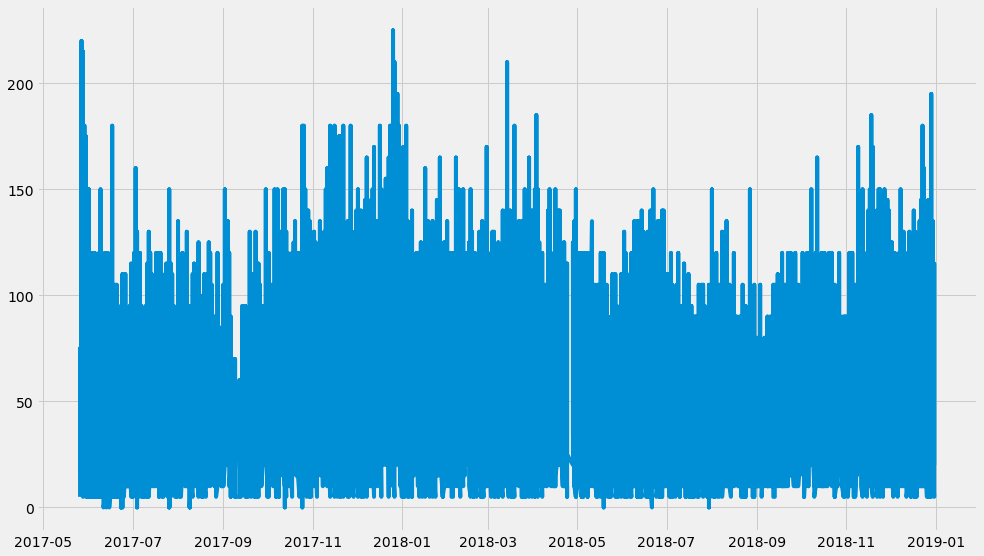

In [27]:
plt.figure(figsize = (15, 9))
plt.plot(navi_thru_18['SPOSTMIN'], label='Pre-Covid Wait Times');

In [28]:
# Step 1: Filter data for one day
# This was the Wednesday after Thanksgiving, 2018

navi_Wed_Dec_05 = navi_thru_18[navi_thru_18.datetime > '2018-12-5']  
navi_Wed_Dec_05 = navi_Wed_Dec_05[navi_Wed_Dec_05.datetime < '2018-12-6']

In [29]:
navi_Wed_Dec_05.set_index('datetime', inplace = True)

In [30]:
navi_Wed_Dec_05.head()

,SACTMIN,SPOSTMIN,weekday,day_name,avg_daily_posted_wait
datetime,,,,,
2018-12-05 08:38:07,NaN,20.0,3,Wednesday,67.912088
2018-12-05 08:45:10,NaN,10.0,3,Wednesday,67.912088
2018-12-05 08:52:08,NaN,10.0,3,Wednesday,67.912088
2018-12-05 08:59:08,NaN,10.0,3,Wednesday,67.912088
2018-12-05 09:00:27,NaN,10.0,3,Wednesday,67.912088


In [31]:
navi_Wed_Dec_05['SPOSTMIN'].max()

115.0

In [32]:
navi_Wed_Dec_05

,SACTMIN,SPOSTMIN,weekday,day_name,avg_daily_posted_wait
datetime,,,,,
2018-12-05 08:38:07,NaN,20.0,3,Wednesday,67.912088
2018-12-05 08:45:10,NaN,10.0,3,Wednesday,67.912088
2018-12-05 08:52:08,NaN,10.0,3,Wednesday,67.912088
2018-12-05 08:59:08,NaN,10.0,3,Wednesday,67.912088
2018-12-05 09:00:27,NaN,10.0,3,Wednesday,67.912088
...,...,...,...,...,...
2018-12-05 17:38:08,NaN,15.0,3,Wednesday,67.912088
2018-12-05 17:45:11,NaN,15.0,3,Wednesday,67.912088
2018-12-05 17:52:09,NaN,25.0,3,Wednesday,67.912088


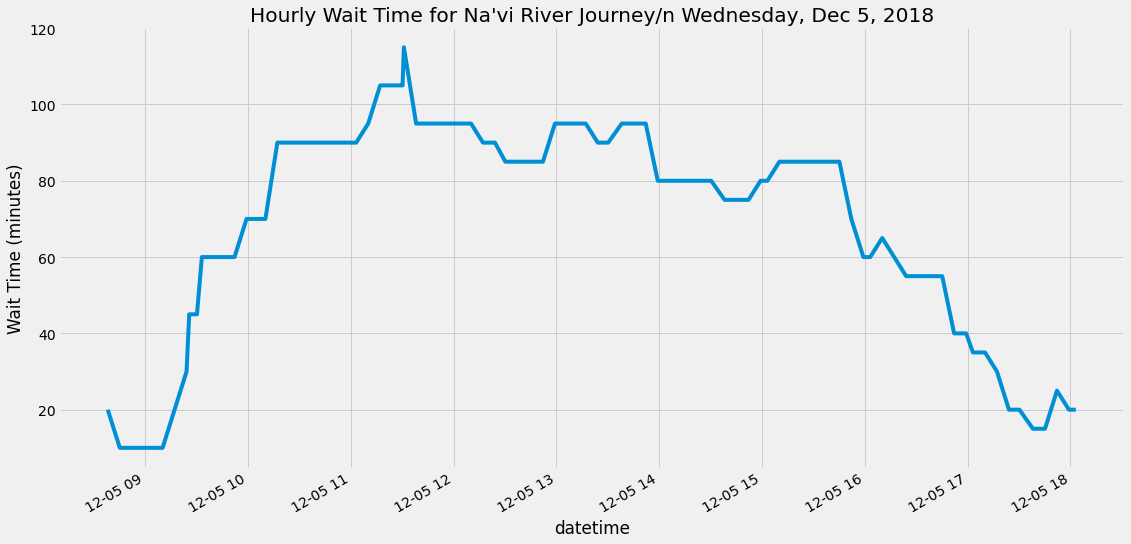

In [33]:
# Step 2: Plot hourly data for Wednesday, Dec 5, 2018

plt.figure(figsize = (17, 9))
plt.title("Hourly Wait Time for Na'vi River Journey/n Wednesday, Dec 5, 2018")
plt.xlabel('Time of Day')
plt.ylabel('Wait Time (minutes)')

# Set title and labels for axes

navi_Wed_Dec_05['SPOSTMIN'].plot();

If guests don't want to use a genie pass for this ride, they should arrive at the park early and ride it first.  The wait time in the evening goes down also, but staff close the ride entrance before the park closes, so that riders are off the ride by closing time.  Remember, this is a lower-volume Wednesday.

In [34]:
# Create data for Saturday, Dec 8, 2018

navi_Sat_Dec_08 = navi_thru_18[navi_thru_18.datetime > '2018-12-7']  
navi_Sat_Dec_08 = navi_Sat_Dec_08[navi_Sat_Dec_08.datetime < '2018-12-8']

navi_Sat_Dec_08.set_index('datetime', inplace = True)

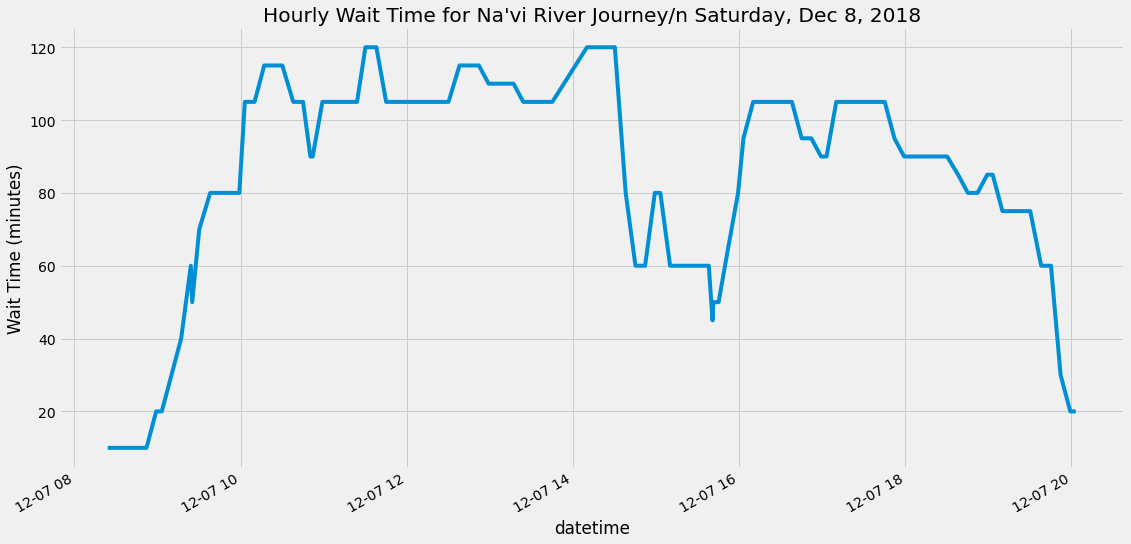

In [35]:
# Step 2: Plot hourly data for Saturday, Dec 8, 2018

plt.figure(figsize = (17, 9))
plt.title("Hourly Wait Time for Na'vi River Journey/n Saturday, Dec 8, 2018")
plt.xlabel('Time of Day')
plt.ylabel('Wait Time (minutes)')
# Set title and labels for axes

navi_Sat_Dec_08['SPOSTMIN'].plot();


Around 3:30pm on Saturday, Dec 8, 2018, the wait time for Na'vi River Journey dropped to around 50 min.  Possibly something to consider, if it's a trend (dinner, kids needing naps, etc.).  Overall, this curve is about the same shape as the Wednesday curve.  It has a few dips mid-day, but otherwise, there is little difference.

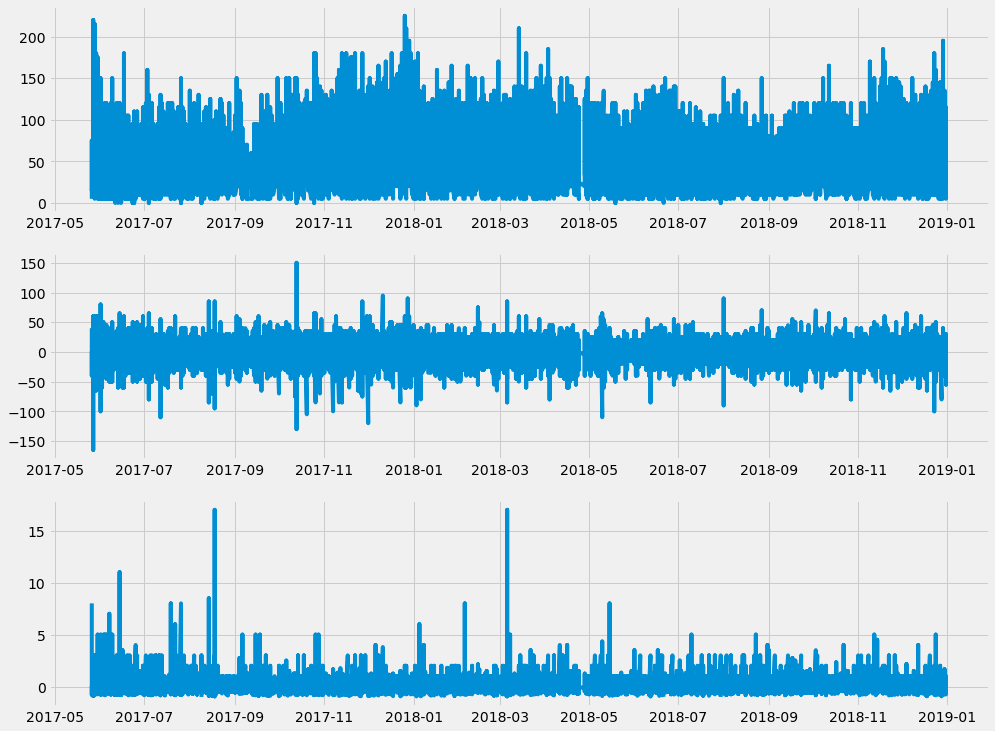

In [36]:
# Plot unchanged, differenced, and percent change
fig, axes = plt.subplots(nrows = 3, figsize = (15, 12))
axes[0].plot(navi_thru_18['SPOSTMIN'])
axes[1].plot(navi_thru_18['SPOSTMIN'].diff())
axes[2].plot(navi_thru_18['SPOSTMIN'].pct_change());

The second plot is differenced data and the third is percent change.  Both plots indicate constant flux with some spikes.  I'd like to see these plots for a single day.

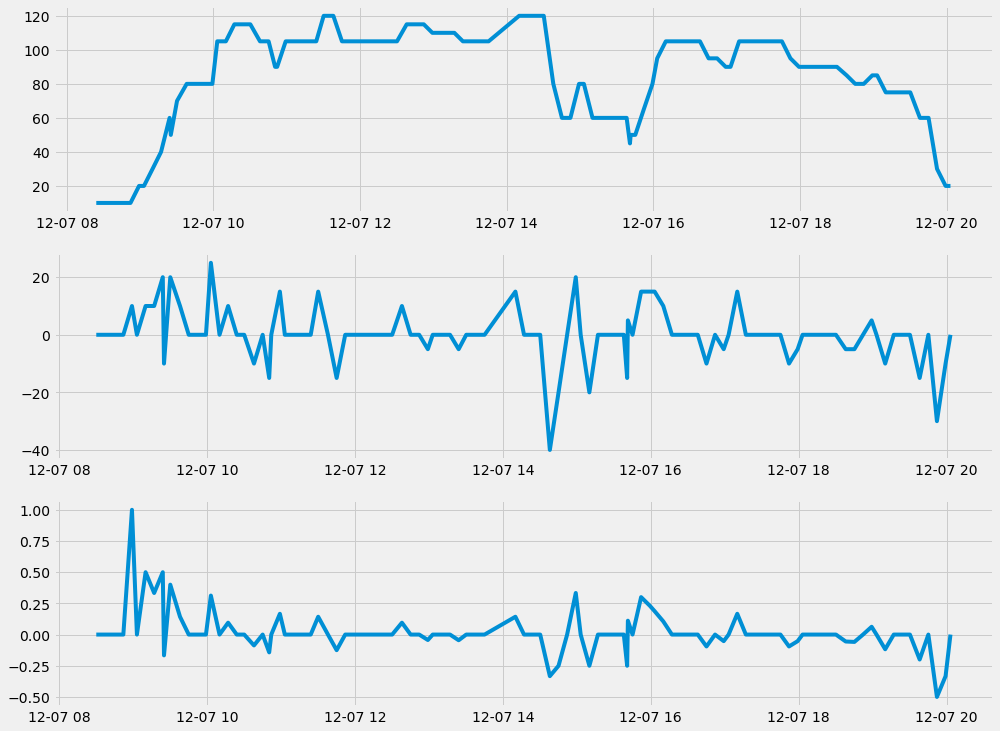

In [37]:
# Plot unchanged, differenced, and percent change
fig, axes = plt.subplots(nrows = 3, figsize = (15, 12))
axes[0].plot(navi_Sat_Dec_08['SPOSTMIN'])
axes[1].plot(navi_Sat_Dec_08['SPOSTMIN'].diff())
axes[2].plot(navi_Sat_Dec_08['SPOSTMIN'].pct_change());

The percent change plot is the most telling here.  For this popular ride, there is a spike at the beginning of the day, followed by smaller fluctuations, some fluctuation around 3:30, as noted previously, and then there is essentially no change until within an hour of park closure.  Those unwilling to use (or purchase) a Genie Pass for this ride either should plan to arrive at the park early and beeline to the ride, look for a gap around an early dinner time, risk snagging a spot in line at the end of the day, or plan on waiting at least 1 hour to ride.

In [38]:
# plt.figure(figsize = (18, 9))

# plt.plot(navi_thru_18['SPOSTMIN'].rolling(1).mean(), label='hourly')
# plt.plot(navi_thru_18['SPOSTMIN'].rolling(12).mean(), label='daily')
#plt.plot(navi_thru_18['SPOSTMIN'].rolling(84).mean(), label='weekly')

#plt.title('Wait Times', fontsize=26)
#plt.ylabel('Wait Times in Minutes', fontsize=18)
#plt.xticks(navi_thru_18.index[0::12], fontsize=14, rotation=90)

#plt.legend(fontsize=18);

Even the weekly rolling mean shows multiple spikes.  A SARIMAX model would be best.

### Split data into pre and during covid datasets

In [ ]:
# Split data into precovid and covid eras
precovid = navi_dt
precovid = precovid[precovid.date < '2020-01-01']
precovid = precovid.groupby('date')
precovid = precovid.resample('10min', loffset=pd.Timedelta('10min')).mean()

precovid

In [ ]:
covid = navi_dt
covid = covid[covid.date > '2020-07-10']
covid = covid.groupby('date')
covid = covid.resample('10min', loffset=pd.Timedelta('10min')).mean()

## Autocorrelation:  ACF & PCF

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/matplotlib/axes/_base.py:2283: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


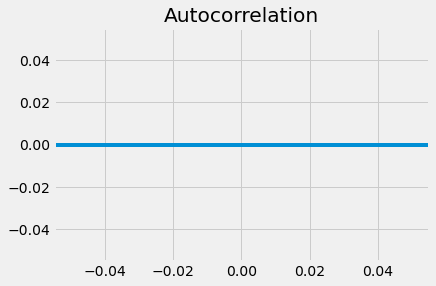

In [73]:
plot_acf(precovid['SPOSTMIN'], lags=420)
plt.show()

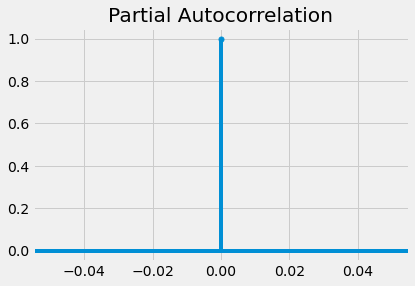

In [74]:
plot_pacf(precovid['SPOSTMIN'], lags=420)
plt.show()

# SARIMAX

In [42]:
navi_thru_18

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,avg_daily_posted_wait
date,,,,,,
2017-05-26,2017-05-26 09:10:12,NaN,5.0,5,Friday,38.896104
2017-05-26,2017-05-26 09:17:09,NaN,45.0,5,Friday,38.896104
2017-05-26,2017-05-26 09:24:07,NaN,45.0,5,Friday,38.896104
2017-05-26,2017-05-26 09:30:10,NaN,45.0,5,Friday,38.896104
2017-05-26,2017-05-26 09:45:32,NaN,45.0,5,Friday,38.896104
...,...,...,...,...,...,...
2018-12-31,2018-12-31 20:30:11,NaN,35.0,1,Monday,67.862903
2018-12-31,2018-12-31 20:38:07,NaN,30.0,1,Monday,67.862903
2018-12-31,2018-12-31 20:45:10,NaN,20.0,1,Monday,67.862903


In [43]:
navi_thru_18.tail()

,datetime,SACTMIN,SPOSTMIN,weekday,day_name,avg_daily_posted_wait
date,,,,,,
2018-12-31,2018-12-31 20:30:11,NaN,35.0,1,Monday,67.862903
2018-12-31,2018-12-31 20:38:07,NaN,30.0,1,Monday,67.862903
2018-12-31,2018-12-31 20:45:10,NaN,20.0,1,Monday,67.862903
2018-12-31,2018-12-31 20:52:09,NaN,20.0,1,Monday,67.862903
2018-12-31,2018-12-31 20:59:07,NaN,20.0,1,Monday,67.862903


### Train-Test Split

In [67]:
# Create train-test split.
train, test = train_test_split(precovid['SPOSTMIN'],
                                  test_size = 0.25,
                                  shuffle = False)

In [66]:
# Weekly SARIMAX

sarimax_model1 = sm.tsa.statespace.SARIMAX(precovid['SPOSTMIN'], order=(2,0,2), seasonal_order=(2,0,2, 7))
results1 = sarimax_model1.fit()

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.87582D+00    |proj g|=  1.06912D+00


 This problem is unconstrained.



At iterate    5    f=  3.42221D+00    |proj g|=  4.40799D-02

At iterate   10    f=  3.40250D+00    |proj g|=  6.08863D-03

At iterate   15    f=  3.39985D+00    |proj g|=  1.17160D-02

At iterate   20    f=  3.39395D+00    |proj g|=  9.68192D-03

At iterate   25    f=  3.39259D+00    |proj g|=  3.62422D-03

At iterate   30    f=  3.39040D+00    |proj g|=  2.44678D-03

At iterate   35    f=  3.38980D+00    |proj g|=  5.95602D-03

At iterate   40    f=  3.38970D+00    |proj g|=  3.11090D-03

At iterate   45    f=  3.38948D+00    |proj g|=  1.46918D-03

At iterate   50    f=  3.38932D+00    |proj g|=  3.33159D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/nadiamorgen/anaconda3/envs/dsi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
